# Diffusion and Dispersion in Solute Transport

This notebook explains the relationship between aquifer heterogeneity and pore-scale dispersion, and provides formulas to convert between them. See [dispersion scales](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-dispersion-scales) and [advection-dominated assumption](https://gwtransport.github.io/gwtransport/user_guide/assumptions.html#assumption-advection-dominated) for background.

## Physical Background: Dispersion as Scale-Dependent Heterogeneity

All spreading in groundwater transport arises from **velocity heterogeneity**. What we call "dispersion" vs "heterogeneity" is simply a matter of observation scale:

| Scale | Mechanism | gwtransport representation |
|-------|-----------|---------------------------|
| Molecular | Brownian motion | $D_m$ [m²/day] (molecular diffusivity) |
| Pore (~mm-cm) | Velocity variations in pores | $\alpha_L$ [m] (longitudinal dispersivity) |
| Aquifer (~m-km) | Different streamline paths | $\sigma_V$ [m³] (std of pore volume distribution) |

**Key insight**: These are the same phenomenon at different resolutions. The boundaries are not sharp—this is why measured $\alpha_L$ increases with experiment scale.

**Prerequisite**: The aquifer pore volume distribution (APVD) is only well-defined and time-invariant under the [steady-streamlines assumption](https://gwtransport.github.io/gwtransport/user_guide/assumptions.html#assumption-steady-streamlines). If the flow field changes in a way that alters streamline geometry (not just velocity), the APVD itself changes.

### The dispersion coefficient and flow velocity

The longitudinal dispersion coefficient is:

$$D_L = D_m + \alpha_L \cdot v$$

$D_L$ **increases with flow velocity** because faster flow drives more vigorous pore-scale mixing. However, the actual spreading of a breakthrough curve at a fixed travel distance $L$ does **not** increase:

| Spreading measure | Molecular diffusion ($D_m$) | Mechanical dispersion ($\alpha_L$) |
|---|---|---|
| Spatial $\sigma_x^2$ | $2 D_m L / v$ — **decreases** with flow | $2 \alpha_L L$ — **constant** |
| Temporal $\sigma_t^2$ | $2 D_m L / v^3$ — **decreases** strongly | $2 \alpha_L L / v^2$ — **decreases** |
| Volume $\sigma_V^2$ | $\propto 1/Q$ — **decreases** | **constant** |

The mechanical dispersion part gives the same spatial spreading regardless of velocity — the plume traverses the same pore structure. The molecular diffusion part gives *less* spreading at higher flow because there is less time for diffusion.

### When to use each approach

| APVD source | Recommendation |
|-------------|----------------|
| **Breakthrough curve fitting** | Use APVD only (dispersion already absorbed in $\sigma_V$) |
| **Streamline analysis (gamma fit)** | Can combine $\alpha_L$ and $D_m$ as equivalent std (variance addition) |
| **Streamline analysis (discrete volumes)** | Must use the `diffusion` module to add pore-scale dispersion — cannot modify discrete volumes by adding/subtracting variance |

## Spreading Components

Breakthrough curve spreading arises from three processes. To compare them, we express each as an **equivalent standard deviation in volume units** [m³]:

| Component | Symbol | Physical cause | Formula in volume units [m³] |
|-----------|--------|----------------|------------------------------|
| **Aquifer heterogeneity** | $\sigma_{V,apv}$ | Different streamline lengths | $\sigma_{V,apv}$ (given) |
| **Molecular diffusion** | $\sigma_{V,diff}$ | Brownian motion | $\frac{\bar{V}}{L} \sqrt{2 D_m \tau}$ |
| **Mechanical dispersion** | $\sigma_{V,disp}$ | Pore-scale velocity variations | $\bar{V} \sqrt{\frac{2 \alpha_L}{L}}$ |

where:
- $\bar{V}$ [m³] is the mean aquifer pore volume
- $L$ [m] is the streamline length  
- $\tau = R \bar{V} / Q$ [day] is the mean solute residence time
- $v = L / \tau$ [m/day] is the pore velocity

**Important distinctions:**
- $\sigma_{V,apv}$ is a **fixed aquifer property** determined by geometry—it does not change with residence time
- $\sigma_{V,diff}$ depends on flow: it **decreases** with higher $Q$ (less time for diffusion)
- $\sigma_{V,disp}$ is **independent of flow**: it depends only on $\alpha_L$ and $L$

### Unit conversions

The same spreading can be expressed in different units:

| Unit | Symbol | Conversion from spatial $\sigma_x$ |
|------|--------|-----------------------------------|
| Spatial [m] | $\sigma_x$ | — |
| Volume [m³] | $\sigma_V$ | $\sigma_V = \sigma_x \cdot \bar{V}/L$ |
| Time [day] | $\sigma_t$ | $\sigma_t = \sigma_x / v = \sigma_x \cdot \tau / L$ |

## Decision Tree: Choosing the Right Approach

```
Q1: How are you planning to obtain your APVD (pore volume distribution)?
│
├─► From breakthrough curve (BTC) fitting
│   │
│   Q2: Is molecular diffusion important? (sigma_{V,diff}² / sigma_{V,disp}² > 0.05)
│   │   AND does flow vary significantly during the tracer test?
│   │
│   ├─► Yes (diffusion important AND variable flow)
│   │   │
│   │   └─► Calibrate using diffusion module (slow)
│   │       Function: diffusion.infiltration_to_extraction
│   │       Fit parameters: mean_apv, std_apv (true APVD heterogeneity)
│   │       The module handles diffusion and variable flow correctly.
│   │       For predictions: use same module, or convert to combined std.
│   │
│   └─► No (diffusion negligible OR flow relatively constant)
│       │
│       └─► Calibrate using advection module (fast)
│           Function: advection.gamma_infiltration_to_extraction
│           Fit parameters: mean_apv, std_apv
│           NOTE: The fitted std absorbs ALL spreading (APVD + diffusion + dispersion).
│           For predictions under similar flow: use advection with same std.
│           For predictions under different flow: see "Key insight" below.
│
└─► From groundwater flow model / streamline analysis
    │
    Q3: Will you approximate APVD as a gamma distribution?
    │
    ├─► Yes (fit gamma to streamline pore volumes)
    │   │
    │   Q4: Is dispersion significant? (sigma_{V,diff}² + sigma_{V,disp}²) / sigma_{V,apv}² > 0.05?
    │   │
    │   ├─► No (< 5% of variance)
    │   │   └─► Use advection.gamma_* with std = sigma_{V,apv}
    │   │
    │   └─► Yes (> 5% of variance)
    │       │
    │       Q5: Is molecular diffusion significant? sigma_{V,diff}² / sigma_{V,disp}² > 0.05?
    │       │
    │       ├─► No → Use advection.gamma_* with std = sqrt(sigma_{V,apv}² + sigma_{V,disp}²)
    │       │
    │       └─► Yes
    │           │
    │           Q6: Is flow relatively constant?
    │           ├─► Yes → Use advection.gamma_* with std = sqrt(sigma_{V,apv}² + sigma_{V,diff}² + sigma_{V,disp}²)
    │           └─► No → Use diffusion module with gamma-distributed pore volumes
    │
    └─► No (use full discrete APVD from streamlines)
        │
        Q7: Is dispersion significant?
        │
        ├─► No → Use advection.infiltration_to_extraction with discrete pore volumes
        │
        └─► Yes
            │
            └─► Use diffusion.infiltration_to_extraction with discrete pore volumes
                NOTE: Variance addition/subtraction CANNOT be used with discrete
                pore volumes. The volumes are specific geometric measurements from
                the flow model—they cannot be meaningfully modified. Pore-scale
                dispersion must be applied on top via the diffusion module.
```

**Why variance combination only works for gamma (continuous) distributions:**
The equivalent std approach works by adjusting the std parameter of a gamma distribution. For discrete streamline volumes from a flow model, each volume is a specific geometric measurement. You cannot "add variance" to an array of fixed values in a physically meaningful way. When pore-scale dispersion matters for discrete APVD, use the `diffusion` module, which applies dispersion along each streamline individually.

**Key insight for BTC-calibrated APVD using advection module:** The fitted $\sigma_{V,apv}$ already includes all spreading that occurred during the tracer test (APVD heterogeneity + diffusion + dispersion). If you predict transport under very different flow conditions (especially much slower flow), diffusion may contribute more than during calibration. In that case, consider:
- Re-calibrating with diffusion module, or
- Using the correction: `std = sqrt(sigma_{V,apv}² + sigma_{V,diff}(Q_pred)² - sigma_{V,diff}(Q_calib)²)`

**Cross-compound calibration:** When the APVD was calibrated using one compound (e.g., temperature with $D_m \approx 0.1$ m²/day) and is used to predict another (e.g., a dissolved solute with $D_m \approx 8.6 \times 10^{-5}$ m²/day), the molecular diffusion contribution baked into the calibrated std is too large for the solute. To correct: subtract the calibration compound's $\sigma_{V,diff}$ and add the target compound's. Similarly, retardation affects $\sigma_{V,diff}$: a more retarded compound spends more time in the aquifer, giving more diffusive spreading.

## Modeling Approaches Summary

| Method | Function | `std` parameter | Speed | When to use |
|--------|----------|----------------|-------|-------------|
| **Gamma APVD only** | `advection.gamma_*` | $\sigma_{V,apv}$ | Fast | BTC fitting, or gamma APVD with negligible dispersion |
| **Gamma + dispersion** | `advection.gamma_*` | $\sqrt{\sigma_{V,apv}^2 + \sigma_{V,disp}^2}$ | Fast | Gamma APVD; $\sigma_{V,diff}^2 \ll \sigma_{V,disp}^2$ |
| **Gamma + diff + disp** | `advection.gamma_*` | $\sqrt{\sigma_{V,apv}^2 + \sigma_{V,diff}^2 + \sigma_{V,disp}^2}$ | Fast | Gamma APVD; constant flow |
| **Discrete APVD** | `advection.infiltration_to_extraction` | N/A | Fast | Streamline APVD; negligible dispersion |
| **Discrete APVD + dispersion** | `diffusion.infiltration_to_extraction` | N/A | Slow | Discrete streamline APVD with significant dispersion |

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from gwtransport import advection, diffusion

np.random.seed(42)
plt.style.use("seaborn-v0_8-whitegrid")

## 1. System Parameters

The input parameters are organized in three groups:
- **Aquifer geometry**: streamline length $L$ and aquifer pore volume distribution (mean $\bar{V}$, std $\sigma_{apv}$)
- **Flow**: mean discharge $Q$
- **Transport**: retardation factor $R$, molecular diffusivity $D_m$, and longitudinal dispersivity $\alpha_L$

In [2]:
# Aquifer geometry
streamline_length = 100.0  # L [m]
mean_apv = 10000.0  # V_mean [m³] Mean aquifer pore volume
std_apv = 800.0  # sigma_apv [m³] Std from aquifer heterogeneity

# Flow
mean_flow = 120.0  # Q [m³/day]

# Transport
retardation = 2.0  # R [-] Retardation factor
diffusivity_molecular = 1e-4  # D_m [m²/day] Molecular diffusion (~1e-9 m²/s)
dispersivity = 1.0  # alpha_L [m] Longitudinal dispersivity

## 2. Equivalent APVD Spreading from Diffusion/Dispersion

To compare diffusion and dispersion with APVD heterogeneity, we convert spatial spreading to **equivalent standard deviation in volume units** [m³]. This allows direct variance addition.

### Conversion from spatial to volume units

Spatial spreading is $\sigma_x$ [m]. To convert to volume units [m³]:
$$\sigma_V = \sigma_x \cdot \frac{\bar{V}}{L} \quad \text{[m³]}$$

This uses the relationship: pore volume $V$ = cross-sectional area × length, so $\bar{V}/L$ [m²] converts length to volume.

### Formulas for equivalent spreading in volume units

After substitution (see derivation below), the formulas simplify to expressions using only input parameters:

$$\sigma_{V,diff} = \frac{\bar{V}}{L} \sqrt{2 D_m \tau} = \frac{\bar{V}}{L} \sqrt{\frac{2 D_m R \bar{V}}{Q}} \quad \text{[m³]}$$

$$\sigma_{V,disp} = \frac{\bar{V}}{L} \sqrt{2 \alpha_L L} = \bar{V} \sqrt{\frac{2 \alpha_L}{L}} \quad \text{[m³]}$$

$$\sigma_{V,diff+disp} = \sqrt{\sigma_{V,diff}^2 + \sigma_{V,disp}^2} = \bar{V} \sqrt{\frac{2 D_m R}{L Q} + \frac{2 \alpha_L}{L}} \quad \text{[m³]}$$

**Flow-dependence**:
- $\sigma_{V,disp}$ is **independent of flow** $Q$: the plume traverses the same pore-scale heterogeneity regardless of velocity
- $\sigma_{V,diff}$ **decreases** with higher $Q$ (proportional to $1/\sqrt{Q}$): faster flow means less time for molecular diffusion

<details>
<summary>Derivation</summary>

Starting from $\sigma_x = \sqrt{2 D \tau}$ [m] and converting to volume units via $\sigma_V = \sigma_x \cdot \bar{V} / L$:

**Molecular diffusion** ($D = D_m$, constant):
$$\sigma_{x,diff} = \sqrt{2 D_m \tau} = \sqrt{2 D_m R \bar{V} / Q} \quad \text{[m]}$$
$$\sigma_{V,diff} = \frac{\bar{V}}{L} \sqrt{\frac{2 D_m R \bar{V}}{Q}} \quad \text{[m³]}$$

**Mechanical dispersion** ($D_{disp} = \alpha_L v = \alpha_L L / \tau$):
$$\sigma_{x,disp}^2 = 2 D_{disp} \tau = 2 \alpha_L \frac{L}{\tau} \tau = 2 \alpha_L L \quad \text{[m²]}$$
$$\sigma_{x,disp} = \sqrt{2 \alpha_L L} \quad \text{[m]}$$
$$\sigma_{V,disp} = \frac{\bar{V}}{L} \sqrt{2 \alpha_L L} = \bar{V} \sqrt{\frac{2 \alpha_L}{L}} \quad \text{[m³]}$$

Note: The retardation factor $R$ cancels out for mechanical dispersion because $D_{disp} \propto v \propto 1/\tau$ and the product $D_{disp} \cdot \tau$ is independent of $\tau$. Physically: a retarded compound moves slower through the same pore structure, experiencing the same heterogeneity over the same distance.

For molecular diffusion, $R$ does **not** cancel: a retarded compound spends more time in the aquifer, giving more time for diffusion to act.

**Combined** (variances add since processes are independent):
$$\sigma_{V,diff+disp}^2 = \sigma_{V,diff}^2 + \sigma_{V,disp}^2$$

</details>

In [3]:
# Equivalent spreading in volume units from molecular diffusion
sigma_v_diff = (mean_apv / streamline_length) * np.sqrt(2 * diffusivity_molecular * retardation * mean_apv / mean_flow)

# Equivalent spreading in volume units from mechanical dispersion
# Note: R cancels out because D_disp = alpha_L * v = alpha_L * L / tau, and D_disp * tau = alpha_L * L
sigma_v_disp = mean_apv * np.sqrt(2 * dispersivity / streamline_length)

# Combined spreading (direct formula)
sigma_v_diff_disp = mean_apv * np.sqrt(
    2 * diffusivity_molecular * retardation / (streamline_length * mean_flow) + 2 * dispersivity / streamline_length
)

print("Equivalent spreading contributions in volume units [m³]:")
print(f"  sigma_v_diff (molecular diffusion):   {sigma_v_diff:6.0f} m³")
print(f"  sigma_v_disp (mechanical dispersion): {sigma_v_disp:6.0f} m³")
print(f"  sigma_v_diff_disp (combined):         {sigma_v_diff_disp:6.0f} m³")

Equivalent spreading contributions in volume units [m³]:
  sigma_v_diff (molecular diffusion):       18 m³
  sigma_v_disp (mechanical dispersion):   1414 m³
  sigma_v_diff_disp (combined):           1414 m³


## 3. Total APVD Standard Deviation (Combining All Sources)

Section 2 computed $\sigma_{diff,disp}$ [m³]—the spreading from diffusion and dispersion **only**.

Now we combine this with the original APVD heterogeneity $\sigma_{apv}$ [m³] to get the **total effective standard deviation**:

$$\sigma_{total} = \sqrt{\sigma_{apv}^2 + \sigma_{diff}^2 + \sigma_{disp}^2} = \sqrt{\sigma_{apv}^2 + \sigma_{diff,disp}^2} \quad \text{[m³]}$$

This is the `std` parameter to use in `advection.gamma_infiltration_to_extraction` when you want to include diffusion/dispersion effects in the fast advection module.

**When is this valid?**
- Only when APVD was obtained from streamline analysis (explicit geometry), not from breakthrough curve fitting (where dispersion is already included in the calibrated std). See [dispersion scales](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-dispersion-scales).
- Only for **gamma-parameterized** (continuous) distributions where the std parameter can be adjusted. For **discrete streamline volumes** from a flow model, variance addition is not meaningful—use the `diffusion` module instead.

In [4]:
# Total std in volume units combining all sources
sigma_v_total = np.sqrt(std_apv**2 + sigma_v_diff_disp**2)

# Variance fractions
var_total = sigma_v_total**2
frac_apv = std_apv**2 / var_total * 100
frac_diff = sigma_v_diff**2 / var_total * 100
frac_disp = sigma_v_disp**2 / var_total * 100

print("Variance contributions to total spreading:")
print(f"  sigma_v_apv  = {std_apv:7.0f} m³  ({frac_apv:5.1f}% of variance) - aquifer heterogeneity")
print(f"  sigma_v_diff = {sigma_v_diff:7.0f} m³  ({frac_diff:5.1f}% of variance) - molecular diffusion")
print(f"  sigma_v_disp = {sigma_v_disp:7.0f} m³  ({frac_disp:5.1f}% of variance) - mechanical dispersion")
print("  " + "-" * 60)
print(f"  sigma_v_total= {sigma_v_total:7.0f} m³  (100.0% of variance)")

print("\n" + "=" * 62)
if frac_diff + frac_disp < 5:
    print("RECOMMENDATION: Use APVD only (sigma_v_apv)")
    print("  -> advection.gamma_* with std=sigma_v_apv")
elif frac_diff < 1:
    print("RECOMMENDATION: Use APVD + dispersion")
    print("  -> advection.gamma_* with std=sqrt(sigma_v_apv^2 + sigma_v_disp^2)")
elif frac_diff + frac_disp < 25:
    print("RECOMMENDATION: Use APVD + diff + disp (constant flow assumed)")
    print("  -> advection.gamma_* with std=sigma_v_total")
else:
    print("RECOMMENDATION: Use full diffusion module for accuracy")
    print("  -> diffusion.infiltration_to_extraction")
print("=" * 62)

Variance contributions to total spreading:
  sigma_v_apv  =     800 m³  ( 24.2% of variance) - aquifer heterogeneity
  sigma_v_diff =      18 m³  (  0.0% of variance) - molecular diffusion
  sigma_v_disp =    1414 m³  ( 75.8% of variance) - mechanical dispersion
  ------------------------------------------------------------
  sigma_v_total=    1625 m³  (100.0% of variance)

RECOMMENDATION: Use APVD + dispersion
  -> advection.gamma_* with std=sqrt(sigma_v_apv^2 + sigma_v_disp^2)


## Using Combined Std with Advection Module (Fast Approach)

When diffusion/dispersion effects are significant but you want the speed of the advection module, use the combined standard deviation. This is valid because both APVD heterogeneity and pore-scale dispersion represent the same physical phenomenon (velocity heterogeneity) at different observation scales—their variances can be added. See [dispersion scales](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-dispersion-scales).

```python
# Option 1: APVD + dispersion only (when σ_diff is negligible)
std_apv_disp = np.sqrt(sigma_apv**2 + sigma_disp**2)

# Option 2: APVD + diff + disp (when flow is relatively constant)
std_total = np.sqrt(sigma_apv**2 + sigma_diff**2 + sigma_disp**2)

# Use in advection module:
cout = advection.gamma_infiltration_to_extraction(
    cin=cin, flow=flow, tedges=tedges, cout_tedges=cout_tedges,
    mean=mean_apv,
    std=std_total,  # or std_apv_disp
    n_bins=nbins,
    retardation_factor=retardation,
)
```

**When is this approach valid?**
- APVD was obtained from streamline analysis (explicit geometry), not breakthrough curve fitting
- APVD is parameterized as a **gamma distribution** (continuous). For discrete streamline volumes, variance cannot be added — use the `diffusion` module instead
- Flow is relatively constant (for $\sigma_{diff}$ calculation which depends on $\tau$)
- You want fast computation with reasonable accuracy

**When to use full diffusion module instead:**
- APVD consists of **discrete pore volumes** from a flow model (variance combination is not possible)
- Flow varies significantly over time
- High precision is required
- You need to model different dispersivities for different pore volumes
- See [advection-dominated assumption](https://gwtransport.github.io/gwtransport/user_guide/assumptions.html#assumption-advection-dominated) for background

## 4. Numerical Validation


In [5]:
n_days = 350
_tedges = pd.date_range("2019-12-31", periods=n_days + 1, freq="D")

_flow = np.full(n_days, mean_flow)
_cin = np.zeros(n_days)
_cin[50] = 100.0

cin_itedges = np.flatnonzero(np.diff(_cin, prepend=1.0, append=1.0))
flow_itedges = np.flatnonzero(np.diff(_flow, prepend=1.0, append=1.0))
itedges = np.unique(np.concatenate([cin_itedges, flow_itedges]))
tedges = _tedges[itedges]

cin = _cin[itedges[:-1]]
flow = _flow[itedges[:-1]]

cout_tedges = _tedges.copy()

nbins = 5000
streamline_lengths = np.full(nbins, streamline_length)

In [10]:
# 1. APVD only (no diffusion/dispersion) - baseline showing aquifer heterogeneity
cout_apvd = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=std_apv,
    n_bins=nbins,
    retardation_factor=retardation,
)

# 2. Full diffusion solution with a SINGLE pore volume (no APVD heterogeneity)
# This is the reference for validating the equivalent std approximation
cout_diffusion_single = diffusion.infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=np.array([mean_apv]),
    streamline_length=np.array([streamline_length]),
    molecular_diffusivity=diffusivity_molecular,
    longitudinal_dispersivity=dispersivity,
    retardation_factor=retardation,
    asymptotic_cutoff_sigma=4.0,
)

# 3. APVD approximation using sigma_v_diff_disp (diffusion + dispersion spreading only)
# This should match cout_diffusion_single since both have no APVD heterogeneity
cout_apvd_approx = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=sigma_v_diff_disp,  # Equivalent std from diffusion + dispersion
    n_bins=nbins,
    retardation_factor=retardation,
)

# 4. Full diffusion solution with MULTIPLE pore volumes (full APVD + diffusion/dispersion)
# This is the slow but physically rigorous approach
from gwtransport import gamma

gamma_bins = gamma.bins(mean=mean_apv, std=std_apv, n_bins=nbins)
pore_volumes = gamma_bins["expected_values"]
cout_diffusion_multi = diffusion.infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    aquifer_pore_volumes=pore_volumes,
    streamline_length=streamline_lengths,
    molecular_diffusivity=diffusivity_molecular,
    longitudinal_dispersivity=dispersivity,
    retardation_factor=retardation,
    asymptotic_cutoff_sigma=4.0,
    suppress_dispersion_warning=True,  # We know what we're doing here
)

# 5. APVD approximation with combined std (APVD + diffusion + dispersion)
# This is the fast approximation - should match cout_diffusion_multi
cout_apvd_total = advection.gamma_infiltration_to_extraction(
    cin=cin,
    flow=flow,
    tedges=tedges,
    cout_tedges=cout_tedges,
    mean=mean_apv,
    std=sigma_v_total,  # Combined std: sqrt(sigma_apv^2 + sigma_diff^2 + sigma_disp^2)
    n_bins=nbins,
    retardation_factor=retardation,
)

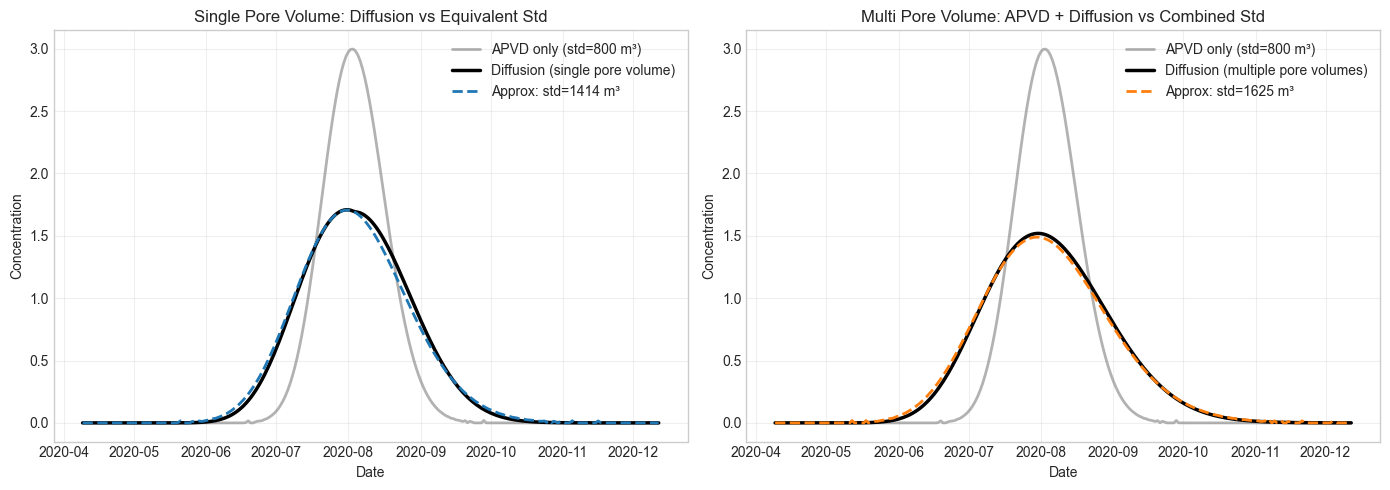

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot around breakthrough
plot_start, plot_end = 100, 349
t_plot = cout_tedges[plot_start:plot_end]

# Left panel: Single pore volume validation
ax1.plot(
    t_plot[:-1],
    cout_apvd[plot_start : plot_end - 1],
    label=f"APVD only (std={std_apv:.0f} m³)",
    linewidth=2,
    alpha=0.6,
    color="gray",
)
ax1.plot(
    t_plot[:-1],
    cout_diffusion_single[plot_start : plot_end - 1],
    label="Diffusion (single pore volume)",
    linewidth=2.5,
    linestyle="-",
    color="black",
)
ax1.plot(
    t_plot[:-1],
    cout_apvd_approx[plot_start : plot_end - 1],
    label=f"Approx: std={sigma_v_diff_disp:.0f} m³",
    linewidth=2,
    linestyle="--",
    color="C0",
)
ax1.set_xlabel("Date")
ax1.set_ylabel("Concentration")
ax1.set_title("Single Pore Volume: Diffusion vs Equivalent Std")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right panel: Multiple pore volumes validation
ax2.plot(
    t_plot[:-1],
    cout_apvd[plot_start : plot_end - 1],
    label=f"APVD only (std={std_apv:.0f} m³)",
    linewidth=2,
    alpha=0.6,
    color="gray",
)
ax2.plot(
    t_plot[:-1],
    cout_diffusion_multi[plot_start : plot_end - 1],
    label="Diffusion (multiple pore volumes)",
    linewidth=2.5,
    linestyle="-",
    color="black",
)
ax2.plot(
    t_plot[:-1],
    cout_apvd_total[plot_start : plot_end - 1],
    label=f"Approx: std={sigma_v_total:.0f} m³",
    linewidth=2,
    linestyle="--",
    color="C1",
)
ax2.set_xlabel("Date")
ax2.set_ylabel("Concentration")
ax2.set_title("Multi Pore Volume: APVD + Diffusion vs Combined Std")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

### Formulas for equivalent APVD spreading [m³]

All formulas convert spatial spreading to APVD units using $\sigma_V = \sigma_x \cdot \bar{V}/L$:

$$\sigma_{diff} = \frac{\bar{V}}{L} \sqrt{\frac{2 D_m R \bar{V}}{Q}} \quad \text{(molecular diffusion — decreases with higher } Q \text{)}$$

$$\sigma_{disp} = \bar{V} \sqrt{\frac{2 \alpha_L}{L}} \quad \text{(mechanical dispersion — independent of } Q \text{; } R \text{ cancels)}$$

$$\sigma_{total} = \sqrt{\sigma_{apv}^2 + \sigma_{diff}^2 + \sigma_{disp}^2} \quad \text{(total spreading)}$$

### Key takeaways

- The dispersion coefficient $D_L = D_m + \alpha_L v$ increases with flow velocity, but the actual breakthrough curve spreading does not increase — it stays constant (mechanical) or decreases (molecular diffusion)
- Variance combination (adding $\sigma_{disp}$ and $\sigma_{diff}$ to $\sigma_{apv}$) is only valid for **gamma-parameterized** APVD from streamline analysis. For **discrete streamline volumes**, use the `diffusion` module
- When APVD is calibrated from breakthrough data, all spreading is already included — do not add dispersion on top
- When calibrating with one compound and predicting for another, account for differing $D_m$ and $R$

### References

- [Dispersion scales](https://gwtransport.github.io/gwtransport/user_guide/concepts.html#concept-dispersion-scales) — Background on scale-dependent dispersion
- [Advection-dominated assumption](https://gwtransport.github.io/gwtransport/user_guide/assumptions.html#assumption-advection-dominated) — When advection-only is appropriate
- [Steady-streamlines assumption](https://gwtransport.github.io/gwtransport/user_guide/assumptions.html#assumption-steady-streamlines) — Prerequisite for APVD to be time-invariant
- [advection module](https://gwtransport.github.io/gwtransport/api/modules.html#module-gwtransport.advection) — Fast advection transport
- [diffusion module](https://gwtransport.github.io/gwtransport/api/modules.html#module-gwtransport.diffusion) — Full advection-dispersion solutions